In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

# !!! Change the Filename accordingly !!!

In [2]:
figure_name = 'figures/fig_8_gaba_ratio_'

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.ndimage.filters import convolve1d
from IPython.display import clear_output
from pathlib import Path
import dill
import pickle

from mpl_toolkits.mplot3d import Axes3D
from skimage import measure

plt.style.use('seaborn-whitegrid')

mpl.rcParams['grid.linestyle'] = ':'   

drawing_size = 12


mpl.rcParams['font.size'] = drawing_size
mpl.rcParams['font.style'] = 'normal'
mpl.rcParams['font.weight']= 'normal'
mpl.rcParams['font.family'] =  ['Arial']



mpl.rcParams['figure.titlesize'] = int(drawing_size*1.0)
mpl.rcParams['figure.titleweight'] = 'heavy'

mpl.rcParams['lines.linewidth'] = int(drawing_size/5)

mpl.rcParams['axes.labelsize'] = drawing_size
mpl.rcParams['axes.labelweight'] = 'heavy'
mpl.rcParams['axes.titlesize'] = int(drawing_size*1.0)
mpl.rcParams['axes.titleweight'] = 'heavy'


mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.fontsize'] = int(drawing_size*0.9)
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 0.5
mpl.rcParams['legend.facecolor'] = 'inherit'
mpl.rcParams['legend.edgecolor'] = '0.8'


mpl.rcParams['figure.figsize'] = [8.0, 5.0]
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300

# print(mpl.rcParams.keys())


In [7]:
class LinearReg():

    def __init__(self, x, y):
        from sklearn.linear_model import LinearRegression

        self.lr_model = LinearRegression()

        self.x = x.reshape(-1, 1)
        self.y = y.reshape(-1, 1)

        self.lr_model.fit(self.x, self.y)

        self.rr = self.lr_model.score(self.x, self.y)

    def get_fitted_line(self):
        return [self.x, self.lr_model.predict(self.x)]

    def get_coefficients(self):
        return self.lr_model.coef_[0, 0], self.lr_model.intercept_[0]

    def get_score(self, x=0, y=0):
        if x == 0 or y == 0:
            return self.rr
        else:
            return self.lr_model.score(x, y)

    def print_coefficients(self):
        print('Gain: {0:1.2f}, Bias: {1:1.2f}, , r^2: {2:1.2f}'.format(self.lr_model.coef_[0, 0], self.lr_model.intercept_[0], self.rr))
        return ('Gain: {0:1.2f},\nBias: {1:1.2f},\n' + r'$r^2$: {2:1.2f}').format(self.lr_model.coef_[0, 0], self.lr_model.intercept_[0], self.rr)


In [8]:


   
############################################################
#                  Simulation parameter                    #
############################################################

# Define initial condition (not necessary?)
#x0 = 0

# Time step
dt = 0.001 # -> 10us

# Solve differential equation from time 0 to time T
T = 12.0 # -> 40ms 

# Descretize time into equal steps
t = np . linspace (0 , T , int ( T / dt )+1)


############################################################
#                Network Inputs/Outputs                    #
############################################################

# define the inputs
# assuming we have 16 frquency bands
freq_bands = 5

############################################################
#                 BPC neuron parameter                     #
#  parameters for r_bpc neuron of LSO, all marked by a _r  #
############################################################
# tau defines how fast the membrane potential builds up
tau_r = 1/40.0
# alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
alpha_r = 1.0
# beta defines the upper limit of the membrane potential
beta_r = 1.0
# gamma defines the subtractive influence of the inhibitory input
gamma_r = 3.0
# kappa defines the divisive influence of the inhibitory input
kappa_r = 4.0

############################################################
#                 PC neuron parameter                      #
#  parameters for q_pc neuron of MNTB, all marked by a _q  #
############################################################
tau_q = 1/40.0
alpha_q = 2.0 
beta_q = 1.0
gamma_q = 0.0
kappa_q = 0.0


In [9]:
############################################################
#                       Functions                          #
############################################################

def mesh_plot(data,ax1):
    # fig is the figure handler
    # data is a 2d array
    # returns the axis of the figure

    # import necessary modules
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import cm
    import matplotlib.pyplot as plt
    # define x and y axis
    x = np.linspace(np.min(data[0, :]), np.max(data[0, :]), data.shape[0])
    y = np.linspace(np.min(data[1, :]), np.max(data[1, :]), data.shape[1])
    # x = np.linspace(0, 1, data.shape[0])
    # y = np.linspace(0, 1, data.shape[1])
    x, y = np.meshgrid(x, y)

    # plot data with nice colors
    ax1.plot_surface(
        x,
        y,
        data.T,
        rstride=1,
        cstride=1,
        cmap=cm.viridis,
        shade=True,
        linewidth=20)

    return ax1




#define a gauss function
def gauss(x,mean,sigma):
    if sigma == 0.0:
        return np.zeros(x.shape)
    else: 
        return np.exp(-(x-mean)**2 /( 2 * sigma**2 ))


# Defines the output transfer function of r_bpc
def g_r_out(r_bpc,a =20,b=0.20):
    return 1 / (1 + np.exp(-(r_bpc-b)*a) )

# Defines the output transfer function of q_pc
def g_q_out(q_pc):
    return np.maximum(q_pc,0)



# Defines the ODE for the r_bpc neuron
def ode_r_bpc(r_bpc,s_sbc,ee_kernel,q_pc,ei_kernel,gaba_exc=0,gaba_inh=0):
    # get the globally defined parameters
    global tau_r ,alpha_r, beta_r, gamma_r, kappa_r

#     # default gaba inhibiton
    # calculate excitatory input, which comes from the SBC cells folded by the E-E kernel
    excitatory_in = convolve1d(s_sbc,weights=ee_kernel,axis=0,mode='reflect')*(1-gaba_exc)
    # calculate inhibitor input, which comes from the q_pc folded by the E-I kernel
    inhibitory_in = convolve1d(g_q_out(q_pc),weights=ei_kernel,axis=0,mode='reflect')*(1-gaba_inh)     
    # calculate the change of r_bpc
    d_r_bpc = -alpha_r * r_bpc + (beta_r-r_bpc) * excitatory_in - ((gamma_r) + kappa_r * r_bpc) * inhibitory_in
    
        
    return d_r_bpc / tau_r


# Defines the ODE for the q_pc neuron
def ode_q_pc(q_pc, s_gbc,ie_kernel,q_pc_all,ii_kernel):
    # get the globally defined parameters
    global tau_q,alpha_q,beta_q,gamma_q,kappa_q

    # calculate excitatory input, which comes from the GBC cells folded by the I-E kernel
    excitatory_in = convolve1d(s_gbc,weights=ie_kernel,axis=0,mode='reflect')
    # calculate inhibitor input, which comes from the q_pc folded by the I-I kernel (self-inhibition)
    inhibitory_in = convolve1d(g_q_out(q_pc_all),weights=ii_kernel,axis=0,mode='reflect')     
    
    d_q_pc = -alpha_q * q_pc + beta_q * excitatory_in - (gamma_q + kappa_q * q_pc) * inhibitory_in 
    
    return d_q_pc /tau_q


# Input

In [10]:
gammas_r = np.arange(0,7,0.5)

In [ ]:

# GABA parameter
gaba_inh = np.linspace(0.0,1,41)
gaba_exc = np.linspace(0.0,1,41)

gammas_r = np.array([1.0,2.0,3.0,4.0,5.0,6.0])
kappas_r = np.array([1.0,2.0,3.0,4.0,5.0,6.0])

gammas_r = np.arange(1.0,6,0.5)
kappas_r = np.arange(1.0,6,0.5)

# gammas_r = np.arange(1.0,7.5,0.5)
# kappas_r = np.arange(1.0,7.5,0.5)
# gammas_r = np.array([4.0,5.0])
# kappas_r = np.array([1.0,2.0,3.0,4.0,5.0])

# to simulate that the gaba influence on the inhibitory side is stronger
# gaba_exc = gaba_inh * 0.7
# gabas = [(i,j) for i in gaba_exc[::-1] for j in gaba_inh]
# ratios = np.linspace(0,2,2)

# store values for different parameters
q_all = np.zeros((len(gaba_inh),len(gaba_exc),len(t),freq_bands))
r_all = np.zeros((len(gaba_inh),len(gaba_exc),len(t),freq_bands))

############################################################
#                      Simulation                          #
############################################################
# for gamma_r in [0.0,1.0,5.0]:
#     for kappa_r in [0.0,1.0,5.0]:

sigma =0.5
ee_kernel = gauss(np.arange(-10*sigma,+10*sigma),0,sigma)
sigma = 0.6
ei_kernel = gauss(np.arange(-10*sigma,+10*sigma),0,sigma)
sigma = 0.1
ie_kernel = gauss(np.arange(-10*sigma,+10*sigma),0,sigma)
sigma = 1.0
ii_kernel = gauss(np.arange(-10*sigma,+10*sigma),0,sigma)

ee_kernel /= np.max(ee_kernel)
ei_kernel /= np.max(ie_kernel)
ie_kernel /= np.max(ie_kernel)
ii_kernel /= np.max(ie_kernel)
ii_kernel = np.zeros(freq_bands)



############################################################
#                       Inputs                             #
############################################################
s_gbc_all= np.zeros((len(t),freq_bands))
s_sbc_all = np.zeros((len(t),freq_bands))

# Define input signal in a plausible way (gaussian input signal over frequency bands?)
# Define input signal in a plausible way (gaussian input signal over frequency bands?)
sigma = 1.0

### MNTB inhibitory input (contra-lateral) ###
gbc_center_frequencyBand =2
gbc_input_strength = 1.0

# build ramps
time_window = 400 # that equals a step of 5dB
for i in range(0,len(t)-time_window,time_window):
    s_gbc_all[i:i+time_window,:] = (i)/(len(t)-time_window) * gbc_input_strength


# # create a linearly decreasing function in frequency band 'center_frequencyband'
# # and smear it with a gauss to effect the neighboring bands
# gbc_gauss_mask = gauss(np.linspace(0,freq_bands,freq_bands),freq_bands/2,sigma)
# s_gbc_all = convolve1d(s_gbc_all,weights=gbc_gauss_mask,axis=1,mode='constant')


# LSO direct excitatory input (ipsi-lateral)
sbc_center_frequencyBand = 2
sbc_input_strength = 1.0

# build ramps
for i in range(0,len(t)-time_window,time_window):
    s_sbc_all[i:i+time_window,:] = (len(t)-time_window-i)/(len(t)-time_window) * sbc_input_strength


# # create a linearly decreasing function in frequency band 'center_frequencyband'
# # and smear it with a gauss to effect the neighboring bands
# sbc_gauss_mask = gauss(np.linspace(0,freq_bands,freq_bands),freq_bands/2,sigma)
# s_sbc_all = convolve1d(s_sbc_all,weights=sbc_gauss_mask,axis=1,mode='constant')


# # Convolve with gauss curve to build a temporal ramp
# gauss_mask = gauss(np.linspace(-50,50,s_gbc_all.shape[0]),0,1)
# s_gbc_all = convolve1d(s_gbc_all,weights=gauss_mask/gauss_mask.sum(),axis=0,mode='constant')
# gauss_mask = gauss(np.linspace(-50,50,s_sbc_all.shape[0]),0,1)
# s_sbc_all = convolve1d(s_sbc_all,weights=gauss_mask/gauss_mask.sum(),axis=0,mode='constant')



# correct for border effect of convolve
s_gbc_all[-130:,gbc_center_frequencyBand] = np.max(s_gbc_all[-130:])
s_sbc_all[:130,sbc_center_frequencyBand] = np.max(s_sbc_all[:130])


filepath = Path('.')


for m,gamma_r in enumerate(gammas_r):
    for n,kappa_r in enumerate(kappas_r):
        # store values for different parameters
        q_all = np.zeros((len(gaba_inh),len(gaba_exc),len(t),freq_bands))
        r_all = np.zeros((len(gaba_inh),len(gaba_exc),len(t),freq_bands))
        file_r = filepath / Path('gaba_r_all_'+str((gamma_r)-1)+'_'+str((kappa_r)-1))
#         print(file_r.as_posix())
        if not file_r.exists():
                
            for k in range(len(gaba_inh)):
                for l in range(len(gaba_exc)):

                    for i in range(0, len(t)-1):
                        # E-E kernel
                        delay_factor = 20
                        # as an MNTB input we use the value of the previously calculated time step. 
                        # By that we have a fix delay between the onset of the signal of direct SBC cells and the MNTB 
                        if i < delay_factor:
                            r_all[l,k,i+1,:] = r_all[l,k,i,:] +  dt * ode_r_bpc(r_all[l,k,i,:],s_sbc_all[i],ee_kernel,np.zeros(q_all.shape[-1]),ei_kernel,gaba_exc[l],gaba_inh[k])       
                        else:
                            r_all[l,k,i+1,:] = r_all[l,k,i,:] +  dt * ode_r_bpc(r_all[l,k,i,:],s_sbc_all[i],ee_kernel,q_all[l,k,i-delay_factor,:],ei_kernel,gaba_exc[l],gaba_inh[k])             

                        q_all[l,k,i+1,:] = q_all[l,k,i,:] +  dt * ode_q_pc(q_all[l,k,i,:],s_gbc_all[i],ie_kernel,q_all[l,k,i,:],ii_kernel)


                    clear_output(wait=True)
                    print(file_r.as_posix(),m,n,k,l)
        
            print('Wrtiting File:',file_r.as_posix())
            with file_r.open('wb') as f:
                pickle.dump(np.squeeze(r_all),f)
                
#         file_q = Path('gaba_q_all_'+str(int(gamma_r)-1)+'_'+str(int(kappa_r)-1))
# 
#         if not file_q.exists():
#             print('Wrtiting File:',file_q.as_posix())
#             with file_q.open('wb') as f:
#                 pickle.dump(np.squeeze(q_all),f)
#         else:
#             print('Found file: ',file_q.as_posix())    
                
                
        else:
            print('Found file: ',file_r.as_posix())

                


In [ ]:
# fig = plt.figure()
# ax2 = fig.add_subplot(111,projection='3d')
# probing_times = np.arange(300,len(t),time_window)
time_window = 400
probing_times = np.arange(2700,len(t)-1800,time_window)

gammas_r = np.arange(1.0,5.5,0.5)
kappas_r = np.arange(1.0,5.5,0.5)

data_path = Path('.')


responses = np.zeros((len(gammas_r),len(kappas_r),len(gaba_inh),len(gaba_exc),len(probing_times)))

# axes = fig.subplots(len(gammas_r),len(kappas_r),squeeze=False)


for m,gamma_r in enumerate(gammas_r):
    for n,kappa_r in enumerate(kappas_r):
        
        
        file_r = filepath / Path('gaba_r_all_'+str((gamma_r-1))+'_'+str((kappa_r-1)))
        # read data
        with file_r.open('rb') as f:
            print(gamma_r,kappa_r)
            print('Reading file: ',file_r.as_posix())
            r_all = pickle.load(f)

#         file_q = data_path / ('gaba_q_all_'+str(m)+'_'+str(n))
#         with file_q.open('rb') as f:
#              q_all = pickle.load(f)


        ## show LSO neuron response
        # probing_times = np.arange(1900,len(t)-1900,time_window)
        probing_times = np.arange(2700,len(t)-1800,time_window)
#         probing_times = np.arange(300,len(t),time_window)
        # probing_times = 5000
        r = np.squeeze(r_all[:,:,:,sbc_center_frequencyBand])
        tmp = -np.array(np.gradient(np.squeeze(g_r_out(r[:,:,probing_times])),axis = 2))

        responses[m,n,:,:,:] = tmp

#         # np.save('gaba_ratios',tmp)

#         # maxi_arg = np.squeeze(np.argmax(tmp,axis=2))
#         maxi = np.squeeze(np.max(tmp,axis=2))


#         c = ax2.pcolormesh(maxi[:,:],cmap='viridis', zorder=-2)
#         ax2.contour(maxi,cmap='viridis', zorder=-1)
#         data_peaks = np.zeros(maxi.shape[0]-20)
        
#         # use the gradien to calculate the peaks
#         grad,_ = np.gradient(maxi)
        
#         for i in range(maxi.shape[0]-20):
#             data_peaks[i] = np.argmax(maxi[:,i])
#             ax2.scatter(i,np.argmax(maxi[:,i]),s=2,linewidth=1,color= 'black', zorder=1)
#         #     print(np.argmax(maxi[:,i]))
#         # calculate linear regression function for peak points (walk on the ridghe of the hill)
#         fit = np.polyfit(range(data_peaks.shape[0]),data_peaks,1)
#         fit_fn = np.poly1d(fit) 
# #         print(fit_fn[1],fit_fn[0]/len(gaba_inh))
#         # ax2.plot(fit_fn(range(maxi.shape[0])),color= 'black', linestyle = '--', zorder=1)
#         ax2.annotate("Gain : {0:0.2f}".format(fit_fn[1]), xy=(maxi.shape[0]/2, 15), xytext=(maxi.shape[0]/2-7, 10))
#         ax2.annotate("Bias : {0:0.2f}".format(fit_fn[0]/len(gaba_inh)), xy=(maxi.shape[0]/2, 15), xytext=(maxi.shape[0]/2-7, 20))

#         # ax2.hlines(30*0.38,0,30)

# #         cbar = plt.colorbar(c)
# #         cbar.set_label('Coding Precision [au]', rotation=270, labelpad=40,)

#         # ax2.set_title('Coding Precision for Various GABA Value Ratios')
#         ax2.set_xlabel(r'$\lambda_E$',fontsize=12)
#         ax2.set_ylabel(r'$\lambda_I$',fontsize=12)



# plt.savefig(figure_name + 'plot.svg', bbox_inches='tight')
# plt.savefig(figure_name + 'plot.pdf', bbox_inches='tight')
# plt.savefig(figure_name + 'plot.tiff', bbox_inches='tight')


plt.show()

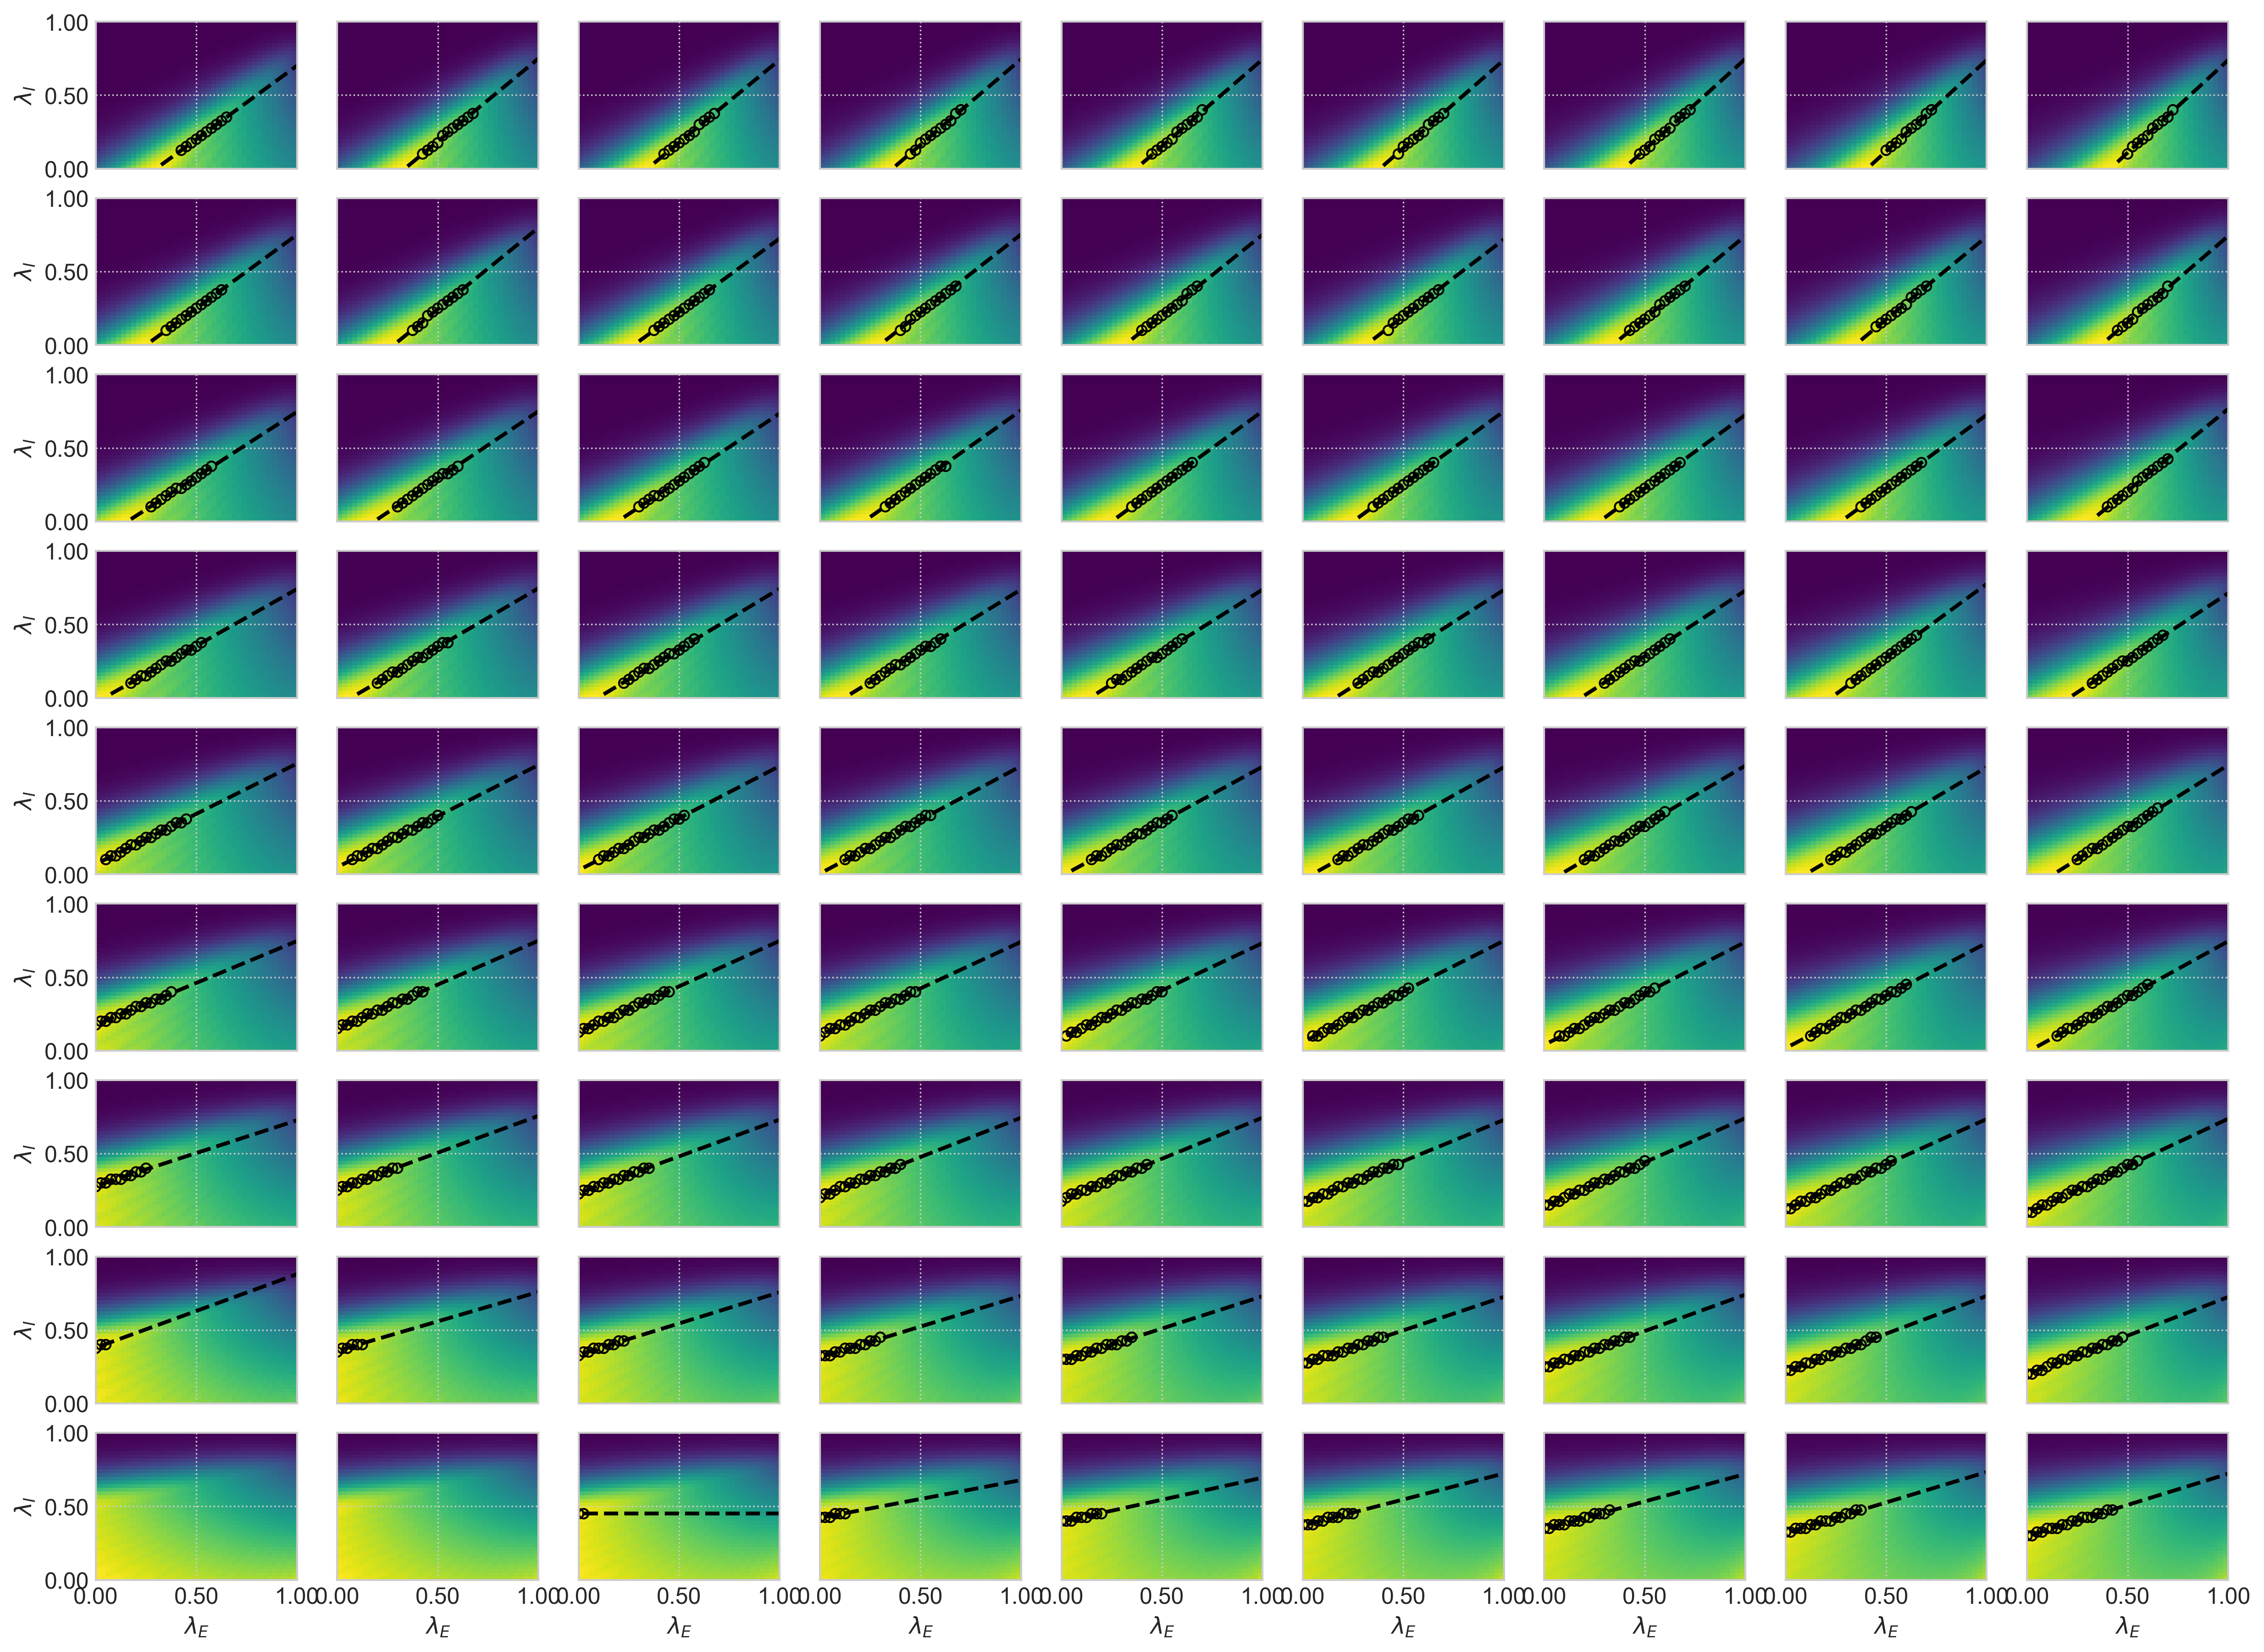

In [18]:
fig = plt.figure(figsize=(20,15))
# ax2 = fig.add_subplot(111,projection='3d')


# gammas_r = np.arange(1.0,6,0.5)
# kappas_r = np.arange(1.0,6,0.5)



axes = fig.subplots(len(gammas_r),len(kappas_r),squeeze=False,sharex=True,sharey=True)
axes = axes[::-1,:]

lin_reg_results = np.zeros((len(gammas_r),len(kappas_r),2))

max_coding_precision = np.zeros((len(gammas_r),len(kappas_r)))

for m,gamma_r in enumerate(gammas_r):
    for n,kappa_r in enumerate(kappas_r):
        
        
     
        ax2 = axes[m,n]
        if m == 0:
            ax2.set_xlabel(r'$\lambda_E$',fontsize=12)

        if n == 0:
            ax2.set_ylabel(r'$\lambda_I$',fontsize=12)

        tmp = responses[m,n]

        # np.save('gaba_ratios',tmp)

        # maxi_arg = np.squeeze(np.argmax(tmp,axis=2))
        maxi = np.squeeze(np.max(tmp,axis=2))


        c = ax2.pcolorfast(maxi[:,:],cmap='viridis', zorder=-2)
#         ax2.contour(maxi,cmap='viridis', zorder=-1)
        data_peaks = np.zeros((maxi.shape[0]-0))
        data_peaks_i = np.zeros((maxi.shape[0]-0))
        
        # use the gradien to calculate the peaks
        grad,_ = np.gradient(maxi)
        
        for i in range(maxi.shape[0]):
            data_peaks[i] = np.argmax(maxi[:,i])
            data_peaks_i[i] = i
            if data_peaks[i] <= 3:
                data_peaks[i] = np.NaN
                data_peaks_i[i] = np.NaN
            
            ax2.scatter(data_peaks_i[i],data_peaks[i],s=25,linewidth=1,facecolors='none',color= 'black', zorder=1)

        max_coding_precision[m,n] = np.max(maxi[:,:])
        #     print(np.argmax(maxi[:,i]))
        # calculate linear regression function for peak points (walk on the ridghe of the hill)
        data_peaks = data_peaks[np.invert(np.isnan(data_peaks))]
        data_peaks_i = data_peaks_i[np.invert(np.isnan(data_peaks_i))]


        
#         data_peaks = data_peaks[np.invert(np.isnan(data_peaks))]
        if len(data_peaks)>1:
#             fit = np.polyfit(range(data_peaks.shape[0]),data_peaks,1)
#             fit_fn = np.poly1d(fit) 
#             print(fit_fn[1],fit_fn[0]/len(gaba_inh))
#             plot()
            lr = LinearReg(data_peaks_i,data_peaks)
            [x,y] = lr.get_fitted_line()
            [g,b] = lr.get_coefficients()
#             print(g,b/len(gaba_inh))
            lin_reg_results[m,n] = [g,b]
            x_range = np.arange(0,41)
            y_range = lr.lr_model.predict(x_range.reshape(-1,1))

            #remove values below y=0
            ind = np.argmin(np.abs(y_range))

            ax2.plot(x_range[ind+1:],y_range[ind+1:],color= 'black', linestyle = '--', zorder=1)
            #ax2.annotate("Gain : {0:0.2f}".format(g), xy=(maxi.shape[0]/2, 15), xytext=(maxi.shape[0]/2-7, 10))
            #ax2.annotate("Bias : {0:0.2f}".format(b/len(gaba_inh)), xy=(maxi.shape[0]/2, 15), xytext=(maxi.shape[0]/2-7, 20))

        ax2.set_xlim([0,40])
        ax2.set_ylim([0,40])
        ax2.set_yticklabels(['{0:.2f}'.format(k) for k in np.linspace(0,1,len(ax2.get_yticks()))])
        ax2.set_xticklabels(['{0:.2f}'.format(k/(maxi.shape[0]-1)) for k in ax2.get_xticks()])

        # ax2.set_title('Coding Precision for Various GABA Value Ratios')
        
        



plt.savefig(figure_name + 'plot.svg', bbox_inches='tight')
plt.savefig(figure_name + 'plot.pdf', bbox_inches='tight')
plt.savefig(figure_name + 'plot.tiff', bbox_inches='tight')


plt.show()

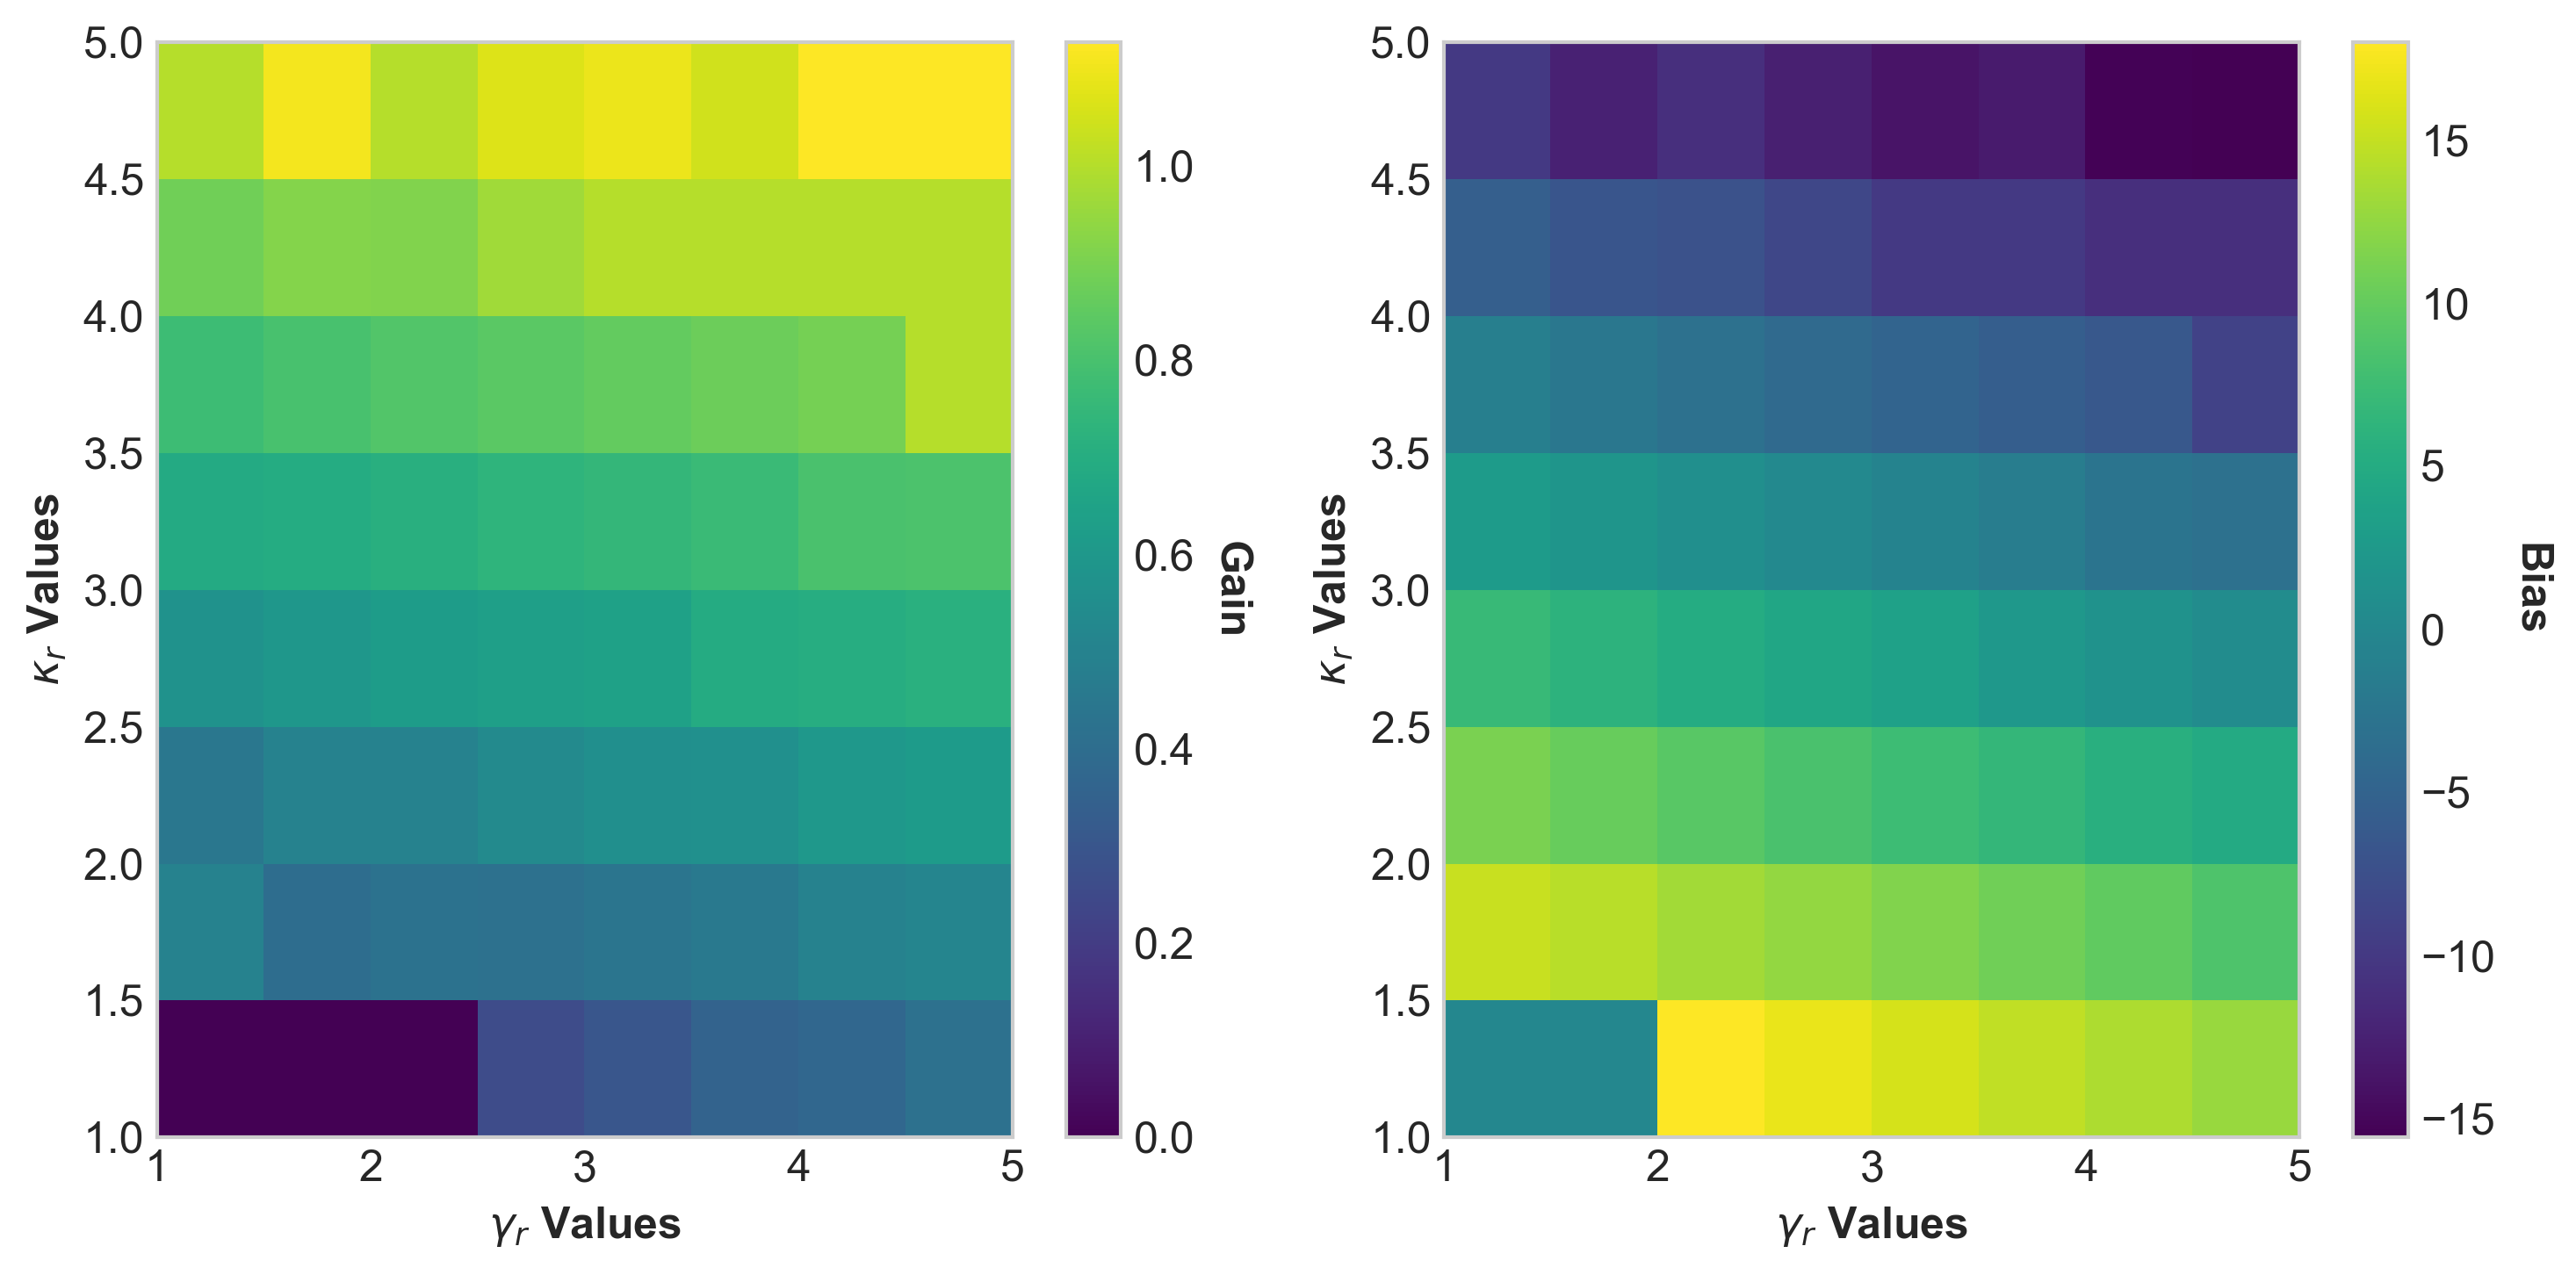

In [15]:
fig = plt.figure(figsize=(10,5))

axes = fig.subplots(1,2,squeeze=False)

ax = axes[0,0]
c = ax.pcolormesh(gammas_r,kappas_r,np.squeeze(lin_reg_results[:,:,0]),cmap='viridis')
# ax.set_xlabel('Gamma Values')
ax.set_xlabel(r'$\gamma_r$ Values',fontsize=12)
# ax.set_ylabel('Kappa Values')
ax.set_ylabel(r'$\kappa_r$ Values',fontsize=12)
cbar = plt.colorbar(c, ax=ax)
cbar.set_label('Gain', rotation=270,labelpad=15)

ax = axes[0,1]
c = ax.pcolormesh(gammas_r,kappas_r,np.squeeze(lin_reg_results[:,:,1]),cmap='viridis')
# ax.set_xlabel('Gamma Values')
ax.set_xlabel(r'$\gamma_r$ Values',fontsize=12)
# ax.set_ylabel('Kappa Values')
ax.set_ylabel(r'$\kappa_r$ Values',fontsize=12)

cbar = plt.colorbar(c, ax=ax)
cbar.set_label('Bias', rotation=270,labelpad = 15)

# ax = axes[0,2]
# c = ax.pcolormesh(gammas_r,kappas_r,np.squeeze(max_coding_precision),cmap='viridis')
# ax.set_xlabel('Gamma Values')
# ax.set_ylabel('Kappa Values')
# cbar = plt.colorbar(c, ax=ax)
# cbar.set_label('Bias', rotation=270,labelpad = 15)


plt.savefig(figure_name + 'gains_bais_summary.svg', bbox_inches='tight')
plt.savefig(figure_name + 'gains_bais_summary.pdf', bbox_inches='tight')
plt.savefig(figure_name + 'gains_bais_summary.tiff', bbox_inches='tight')

plt.tight_layout()
plt.show()

In [19]:
gammas_r

array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])